In [23]:
import numpy as np
from scipy import spatial 
import faiss
from time import time
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans

## Helper Function

In [2]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [3]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [4]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [5]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [6]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells and add the following results to the report:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [94]:
query_vectors = np.load('data/query_vectors.npy')
index_vectors = np.load('data/index_vectors.npy')
k=10
dim = index_vectors.shape[1]

In [189]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: total: 35.8 s
Wall time: 40.5 s


In [191]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: total: 4.09 s
Wall time: 3.5 s


In [192]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: total: 1.91 s
Wall time: 544 ms


In [194]:
faiss_lsh_ann.shape

(1000, 10)

In [193]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.138


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.8.

The last three bullets should also appear in the report.
You are allowed to add as many helper functions as you need. You cannot use faiss of scipy libraries for this task. Numpy is allowed. 

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:

    query_vectors = np.load('data/query_vectors2.npy')
    index_vectors = np.load('data/index_vectors2.npy')
or:

    query_vectors = np.load('data/query_vectors3.npy')
    index_vectors = np.load('data/index_vectors3.npy')
    
the aforementioned requirements should also be satisfied over these two query-index sets. No need to insert the results over these two to the report.

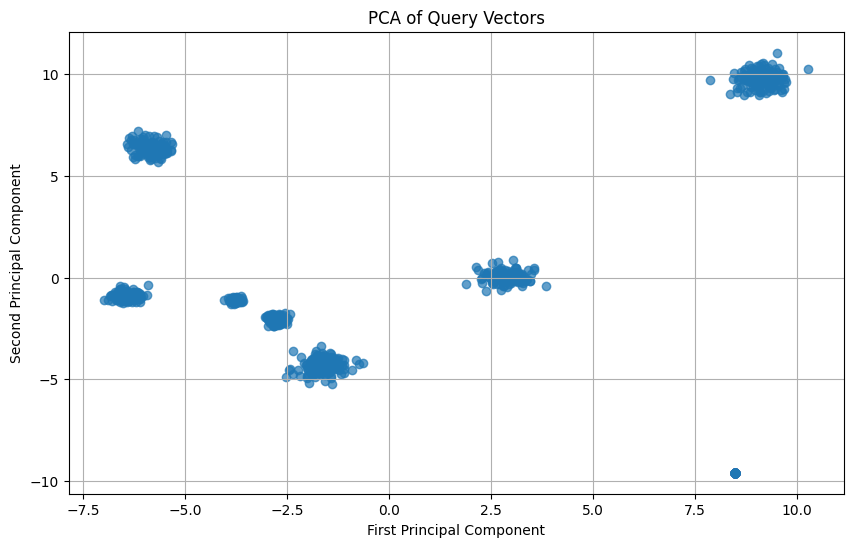

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


query_vectors = np.load('data/query_vectors2.npy')
index_vectors = np.load('data/index_vectors2.npy')

# Standardize the data (optional but recommended)

scaler = StandardScaler()
query_vectors_std = scaler.fit_transform(query_vectors)

# Perform PCA
pca = PCA(n_components=2)  # Change n_components to the number of dimensions you want to keep
query_vectors_pca = pca.fit_transform(query_vectors_std)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(query_vectors_pca[:, 0], query_vectors_pca[:, 1], alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Query Vectors')
plt.grid(True)
plt.show()

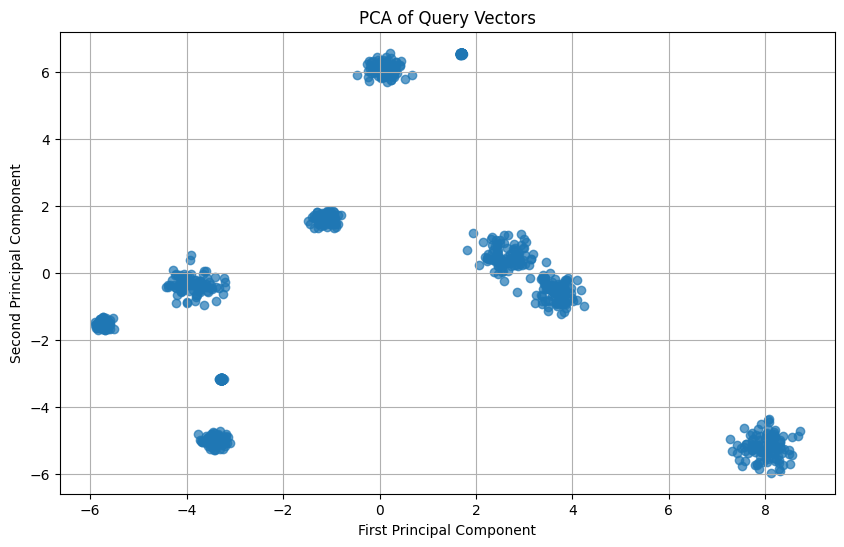

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


query_vectors = np.load('data/query_vectors3.npy')
index_vectors = np.load('data/index_vectors3.npy')

# Standardize the data (optional but recommended)

scaler = StandardScaler()
query_vectors_std = scaler.fit_transform(query_vectors)

# Perform PCA
# pca = PCA(n_components=2)  # Change n_components to the number of dimensions you want to keep
# query_vectors_pca = pca.fit_transform(query_vectors_std)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(query_vectors_pca[:, 0], query_vectors_pca[:, 1], alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Query Vectors')
plt.grid(True)
plt.show()

In [253]:
#TODO: Write your code for 2.2.2 here
# You are allowed to add more arguments to the functions and create more functions if needed.

def update_k_means_centroids(vectors, n_clusters, centroids):
    distances = np.linalg.norm(vectors[:, np.newaxis] - centroids, axis=2)
    labels = np.argmax(distances, axis=1)
    new_centroids = np.array([vectors[labels == cluster_id].mean(axis=0) for cluster_id in range(n_clusters)])
    return new_centroids

def separate_to_clusters(vectors, centroids):
    distances = np.linalg.norm(vectors[:, np.newaxis] - centroids, axis=2)
    labels = np.argmax(distances, axis=1)
    clusters_vectors = {}
    clusters_vector_ids = {}
    for vector_id, (vector, label) in enumerate(zip(vectors, labels)):
        if label in clusters_vectors:
            clusters_vectors[label].append(vector)
            clusters_vector_ids[label].append(vector_id)
        else:
            clusters_vectors[label] = [vector,]
            clusters_vector_ids[label] = [vector_id,]
            
    for label in clusters_vectors:
        clusters_vectors[label] = np.array(clusters_vectors[label])
        clusters_vector_ids[label] = np.array(clusters_vector_ids[label])
            
    return clusters_vectors, clusters_vector_ids
    

def calc_k_means_clusters(vectors, n_clusters, max_iter=100):
    iter = 0
    initial_indices = np.random.choice(index_vectors.shape[0], n_clusters, replace=False)
    centroids = index_vectors[initial_indices]
    prev_centroids = centroids
    centroids = update_k_means_centroids(vectors, n_clusters, centroids)
    while not np.array_equal(centroids, prev_centroids) and iter < max_iter:
        prev_centroids = centroids
        centroids = update_k_means_centroids(vectors, n_clusters, centroids)
        iter += 1

    clusters_vectors, clusters_vector_ids = separate_to_clusters(vectors, centroids)
    
    return centroids, clusters_vectors, clusters_vector_ids


def custom_indexing_algorithm(index_vectors, dim):
    """
    This function builds an index from scratch.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        An index.
    """
    n_clusters = 200
    centroids, clusters_vectors, clusters_vector_ids = calc_k_means_clusters(index_vectors, n_clusters)
    return centroids, clusters_vectors, clusters_vector_ids


def custom_index_search(query_vectors, index, k):
    """
    This function searches over the custom index.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: The custom index.
        k: The number of nearest neighbors to retrieve.
    """
    centroids, clusters_vectors, clusters_vector_ids = index
    query_centroid_distances = np.linalg.norm(query_vectors[:, np.newaxis] - centroids, axis=2)
    labels = np.argmax(query_centroid_distances, axis=1)
    
    ann_lists = []
    
    for query_vector, label in zip(query_vectors, labels):
        cluster_index_vectors = clusters_vectors[label]
        cluster_index_vectors_ids = clusters_vector_ids[label]
        
        distances = np.linalg.norm(cluster_index_vectors - query_vector, axis=1)
        ann_lists.append(cluster_index_vectors_ids[np.argsort(distances)[:k]])
        
    return np.array(ann_lists)
    

In [254]:
# Add hyperparameters here (if needed)

In [255]:
%%time
custom_index = custom_indexing_algorithm(index_vectors, dim)

C:\Users\yonil\AppData\Local\Temp\ipykernel_25584\3089159381.py:7: RuntimeWarning: Mean of empty slice.
  new_centroids = np.array([vectors[labels == cluster_id].mean(axis=0) for cluster_id in range(n_clusters)])


KeyboardInterrupt: 

In [256]:
%%time
custom_index_ann = custom_index_search(query_vectors[:2], custom_index, k)

CPU times: total: 93.8 ms
Wall time: 159 ms


In [257]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn[:2], custom_index_ann, k)}")

recall@10 for custom_index_search: 1.0
